In [2]:
# Data manipulation
import numpy as np
import matplotlib.pyplot as plt

# Model training
from sklearn.mixture import GaussianMixture as GMM
from sklearn import preprocessing
import pickle

# Feature extraction
import librosa
import scipy
import python_speech_features as mfcc
import os
from scipy.io.wavfile import read

# Live recording
import sounddevice as sd
import soundfile as sf

In [3]:
def get_MFCC(sr,audio):
    
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = False)
    features = preprocessing.scale(features)
    
    return features

In [5]:
def get_features(source):
    
    # Split files
    files = [os.path.join(source,f) for f in os.listdir(source) if f.endswith('.wav')]
    len_train = int(len(files)*0.8)
    train_files = files[:len_train]
    test_files = files[len_train:]
    
    # Train features
    features_train = []
    for f in train_files:
        sr, audio = read(f)
        vector = get_MFCC(sr,audio)
        if len(features_train) == 0:
            features_train = vector
        else:
            features_train = np.vstack((features_train, vector))
            
    # Test features  
    features_test = []
    for f in test_files:
        sr, audio = read(f)
        vector = get_MFCC(sr,audio)
        if len(features_test) == 0:
            features_test = vector
        else:
            features_test = np.vstack((features_test, vector))
            
    return features_train, features_test

In [6]:
source = "AudioSet/male_clips"
features_train_male, features_test_male = get_features(source)
gmm_male = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)
gmm_male.fit(features_train_male)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

In [7]:
source = "AudioSet/female_clips"
features_train_female, features_test_female =  get_features(source)
gmm_female = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_female.fit(features_train_female)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

NameError: name 'features_male' is not defined

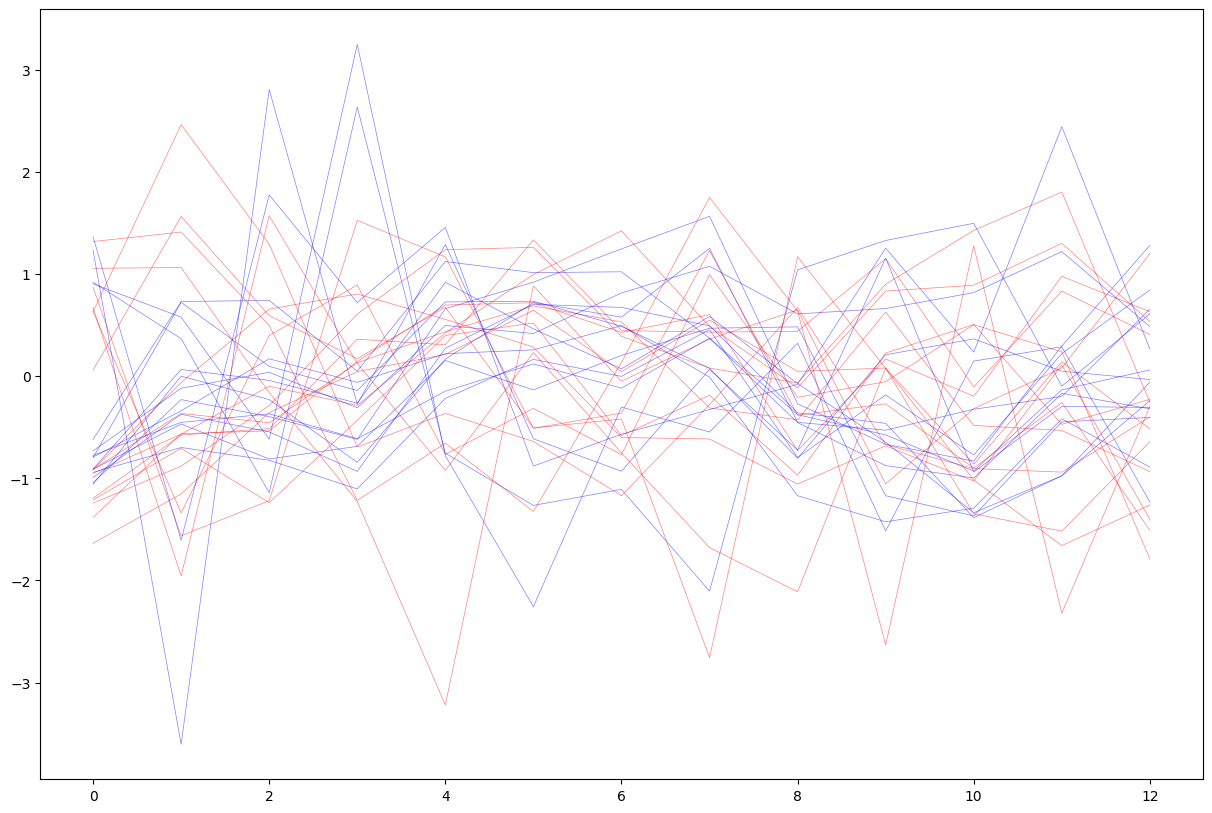

In [13]:
plt.figure(figsize=(15,10))
for i in range(0, 15000, 1000):
    plt.plot(features_train_male[i], c='b', linewidth=0.5, alpha=0.5)
    plt.plot(features_train_female[i], c='r', linewidth=0.5, alpha=0.5)
plt.plot(features_male[i+1], c='b', label="Male", linewidth=0.5, alpha=0.5)
plt.plot(features_female[i+1], c='r', label="Female", linewidth=0.5, alpha=0.5)
plt.legend()
plt.title("MFCC features for Males and Females")
plt.show()

In [7]:
output = []

for f in features_test_male:

    log_likelihood_male = np.array(gmm_male.score([f])).sum()
    log_likelihood_female = np.array(gmm_female.score([f])).sum()
    
    if log_likelihood_male > log_likelihood_female:
        output.append(0)
    else:
        output.append(1)


In [8]:
accuracy_male = (1 - sum(output)/len(output))
accuracy_male

0.9065252854812398

In [ ]:
def get_features(source):
    
    files = [os.path.join(source,f) for f in os.listdir(source) if f.endswith('.wav')]
    
    features = []
    for f in files:
        sr,audio = read(f)
        vector   = get_MFCC(sr,audio)
        if len(features) == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

    return features

source_male = "AudioSet/male_clips"
features_male = get_features(source_male)

gmm_male = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_male.fit(features_male)

source_female = "AudioSet/female_clips"
features_female = get_features(source_female)

gmm_female = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_female.fit(features_female)

# Save models
pickle.dump(gmm_male, open("male.gmm", "wb" ))
pickle.dump(gmm_female, open("female.gmm", "wb" ))

In [ ]:
def record_and_predict(sr=16000, channels=1, duration=5, filename='7.wav'):
    
    recording = sd.rec(int(duration * sr), samplerate=sr, channels=channels).reshape(-1)
    sd.wait()
    
    features = get_MFCC(sr,recording)
    scores = None

    log_likelihood_male = np.array(gmm_male.score(features)).sum()
    log_likelihood_female = np.array(gmm_female.score(features)).sum()

    if log_likelihood_male >= log_likelihood_female:
        return("Male")
    else:
        return("Female")

In [ ]:
record_and_predict()